# Using SGD on MNIST

## ... about machine learning (a reminder from lesson 1)

The good news is that modern machine learning can be distilled down to a couple of key techniques that are of very wide applicability. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

1. Ensembles of decision trees (i.e. Random Forests and Gradient Boosting Machines), mainly for **structured data** (such as you might find in a database table at most companies).  We looked at random forests in depth as we analyzed the Blue Book for Bulldozers dataset.

2. Multi-layered neural networks learnt with SGD (i.e. shallow and/or deep learning), mainly for **unstructured data** (such as audio, vision, and natural language)

In this lesson, we will start on the 2nd approach (a neural network with SGD) by analyzing the MNIST dataset.  You may be surprised to learn that **logistic regression is actually an example of a simple neural net**!

## About The Data

In this lesson, we will be working with MNIST, a classic data set of hand-written digits.  Solutions to this problem are used by banks to automatically recognize the amounts on checks, and by the postal service to automatically recognize zip codes on mail.

<img src="images/mnist.png" alt="" style="width: 60%"/>

A matrix can represent an image, by creating a grid where each entry corresponds to a different pixel.

<img src="images/digit.gif" alt="digit" style="width: 55%"/>
  (Source: [Adam Geitgey
](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721))


### Imports

We will be using the fastai library, which is still in pre-alpha.  If you are accessing this course notebook, you probably already have it downloaded, as it is in the same Github repo as the course materials.

We use [symbolic links](https://kb.iu.edu/d/abbe) (often called *symlinks*) to make it possible to import these from your current directory.  For instance, I ran:

    ln -s ../../fastai
    
in the terminal, within the directory I'm working in, `home/fastai/courses/ml1`.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

### Download

Let's download, unzip, and format the data.

In [4]:
path = '../data/'

In [5]:
import os
os.makedirs(path, exist_ok=True)

In [6]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [7]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [8]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

### Normalize

Many machine learning algorithms behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. We will subtract off the mean and standard deviation from our training set in order to normalize the data:

In [9]:
mean = x.mean()
std = x.std()

In [10]:
x=(x-mean)/std
x.mean(), x.std()

(-3.1638146e-07, 0.99999934)

Note that for consistency (with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. 

In [11]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

### Look at the data

In any sort of data science work, it's important to look at your data, to make sure you understand the format, how it's stored, what type of values it holds, etc. To make it easier to work with, let's reshape it into 2d images from the flattened 1d format.

#### Helper methods

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [13]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation='none', cmap='gray')

#### Plots 

In [13]:
x.shape

(50000, 784)

In [14]:
x_valid.shape

(10000, 784)

In [15]:
x_valid

array([[-0.42452, -0.42452, -0.42452, ..., -0.42452, -0.42452, -0.42452],
       [-0.42452, -0.42452, -0.42452, ..., -0.42452, -0.42452, -0.42452],
       [-0.42452, -0.42452, -0.42452, ..., -0.42452, -0.42452, -0.42452],
       ..., 
       [-0.42452, -0.42452, -0.42452, ..., -0.42452, -0.42452, -0.42452],
       [-0.42452, -0.42452, -0.42452, ..., -0.42452, -0.42452, -0.42452],
       [-0.42452, -0.42452, -0.42452, ..., -0.42452, -0.42452, -0.42452]], dtype=float32)

- Originally, each img is stored flatten in a 1-D array with 784 pixels, and we have 10,000 imgs (10000, 784).

- For the convenience of showing img, we convert 1-D array back to 2-D array, so each img is $28*28$, and we have 10,000 imgs (10000, 28, 28)

In [16]:
# -1 means the length is infered from other dimension
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

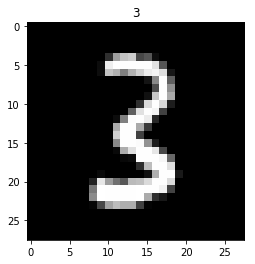

In [17]:
# y_valid[0] is to plot title
show(x_imgs[0], y_valid[0])

In [18]:
y_valid.shape

(10000,)

It's the digit 3!  And that's stored in the y value:

In [19]:
y_valid[0]

3

We can look at part of an image:

In [20]:
x_imgs[0,10:15,10:15]

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

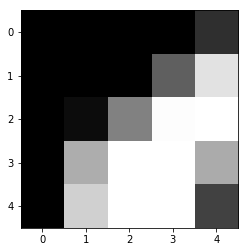

In [21]:
show(x_imgs[0,10:15,10:15])

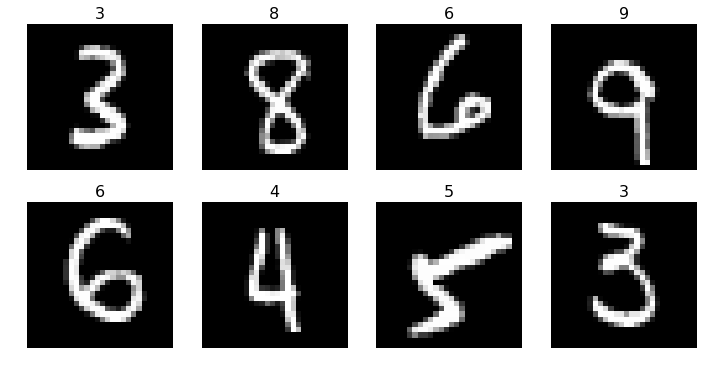

In [22]:
plots(x_imgs[:8], titles=y_valid[:8])

## Logistic regression

In [22]:
from sklearn import linear_model, metrics

Let's start by using the sklearn implementation:

In [23]:
regr = linear_model.LogisticRegression(C=50. / len(x),
                                     # multi_class='multinomial',
                                     # penalty='l2', 
                                     #  tol=0.1
                                      )
# %timeit regr.fit(x, y)

In [24]:
regr.fit(x,y)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training set error:

In [25]:
pred = regr.predict(x)
pred

array([5, 0, 4, ..., 8, 4, 8])

In [26]:
(pred == y).sum()/len(pred)

0.90502000000000005

In [27]:
pred = regr.predict(x_valid)

Validation Set Error:

In [28]:
(pred == y_valid).sum()/len(pred)

0.91369999999999996

We are getting 91% accuracy with our logistic regression model. Not bad for our 1st attempt.

#### Metrics

It will be helpful to have some metrics on how good our prediciton is.  We will look at the mean squared norm (L2) and mean absolute error (L1).

In [29]:
def regr_metrics(act, pred):
    return (math.sqrt(metrics.mean_squared_error(act, pred)), 
     metrics.mean_absolute_error(act, pred))

In [30]:
regr_metrics(y_valid, regr.predict(x_valid))

(1.2376186811776881, 0.31690000000000002)

## Neural Networks

To take a deeper look at what logistic regression is doing and how we can program it ourselves, we are going to put it in context as a specific example of a shallow neural net.

**What is a neural network?**

A *neural network* is an *infinitely flexible function*, consisting of *layers*.  **A *layer* is matrix multiplication (which is linear) followed by a non-linear function (the *activation*).**

One of the tricky parts of neural networks is just keeping track of all the vocabulary! 

### Functions, parameters, and training

A **function** takes inputs and returns outputs. For instance, $f(x) = 3x + 5$ is an example of a function.  If we input $2$, the output is $3\times 2 + 5 = 11$, or if we input $-1$, the output is $3\times -1 + 5 = 2$

Functions have **parameters**. The above function $f$ is $ax + b$, with parameters a and b set to $a=3$ and $b=5$.

Machine learning is often about learning the best values for those parameters.  For instance, suppose we have the data points on the chart below.  What values should we choose for $a$ and $b$?

<img src="images/sgd2.gif" alt="" style="width: 70%"/>

In the above gif from the fast.ai Practical Deep Learning for Coders course, [intro to SGD notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/sgd-intro.ipynb)), an algorithm called stochastic gradient descent is being used to learn the best parameters to fit the line to the data (note: in the gif, the algorithm is stopping before the absolute best parameters are found).  This process is called **training** or **fitting**.

Most datasets will not be well-represented by a line.  We could use a more complicated function, such as $g(x) = ax^2 + bx + c + \sin d$.  Now we have 4 parameters to learn: $a$, $b$, $c$, and $d$.  This function is more flexible than $f(x) = ax + b$ and will be able to accurately model more datasets.

Neural networks take this to an extreme, and are **infinitely flexible (it can replicate any functions)**.  They often have thousands, or even hundreds of thousands of parameters.  However the core idea is the same as above.  The neural network is a function, and we will learn the best parameters for modeling our data.

## PyTorch

We will be using the open source [deep learning library, fastai](https://github.com/fastai/fastai), which provides high level abstractions and best practices on top of PyTorch.  This is the highest level, simplest way to get started with deep learning. Please note that fastai requires Python 3 to function. It is currently in pre-alpha, so items may move around and more documentation will be added in the future.

The fastai deep learning library uses [PyTorch](http://pytorch.org/), a Python framework for dynamic neural networks with GPU acceleration, which was released by Facebook's AI team.

PyTorch has two overlapping, yet distinct, purposes.  As described in the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="images/what_is_pytorch.png" alt="pytorch" style="width: 80%"/>

The neural network functionality of PyTorch is built on top of the Numpy-like functionality for fast matrix computations on a GPU. Although the neural network purpose receives way more attention, both are very useful.  We'll implement a neural net from scratch today using PyTorch.

**Further learning**: If you are curious to learn what *dynamic* neural networks are, you may want to watch [this talk](https://www.youtube.com/watch?v=Z15cBAuY7Sc) by Soumith Chintala, Facebook AI researcher and core PyTorch contributor.

If you want to learn more PyTorch, you can try this [introductory tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [tutorial to learn by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

### About GPUs

Graphical processing units (GPUs) allow for matrix computations to be done with much greater speed, as long as you have a library such as PyTorch that takes advantage of them.  Advances in GPU technology in the last 10-20 years have been a key part of why neural networks are proving so much more powerful now than they did a few decades ago. 

You may own a computer that has a GPU which can be used.  For the many people that either don't have a GPU (or have a GPU which can't be easily accessed by Python), there are a few differnt options:

- **Don't use a GPU**: For the sake of this tutorial, you don't have to use a GPU, although some computations will be slower.  The only change needed to the code is to remove `.cuda()` wherever it appears.
- **Use crestle, through your browser**: [Crestle](https://www.crestle.com/) is a service that gives you an already set up cloud service with all the popular scientific and deep learning frameworks already pre-installed and configured to run on a GPU in the cloud. It is easily accessed through your browser. New users get 10 hours and 1 GB of storage for free. After this, GPU usage is 34 cents per hour. I recommend this option to those who are new to AWS or new to using the console.
- **Set up an AWS instance through your console**: You can create an AWS instance with a GPU by following the steps in this  [fast.ai setup lesson](http://course.fast.ai/lessons/aws.html).]  AWS charges 90 cents per hour for this.

## Neural Net for Logistic Regression in PyTorch

In [14]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *
from fastai.core import *

import torch.nn as nn

We will begin with the highest level abstraction: using a neural net defined by PyTorch's Sequential class.  

* The parameters of nn.Linear is number of columns of input matrix and number of columns of output matrix


* The number of rows of input matrix depends on mini batch size(64 for fastai)


* So the input matrix is (64, 784), and the weight matrix is (784, 100)


* The output matrix, which is the result of matrix product, has shape (64,100)

In [15]:
net = nn.Sequential(
    nn.Linear(28*28, 10),  # first layer, linear layer, input is 784, output is 10; these numbers are columns
    nn.LogSoftmax()        # second layer, non-linear layer
).cuda()  # run on the GPU

In [33]:
net = nn.Sequential(
    nn.Linear(28*28, 100), # linear, input 784, output 100
    nn.ReLU(),             # non-linear
    nn.Linear(100, 100),   # linear, input 100, output 100
    nn.ReLU(),             # non-linear
    nn.Linear(100, 10),    # linear, input 100, output 10
    nn.LogSoftmax()        # non-linear
).cuda()

Each input is a vector of size $28\times 28$ pixels and our output is of size $10$ (since there are 10 digits: 0, 1, ..., 9). 

We use the output of the final layer to generate our predictions.  Often for classification problems (like MNIST digit classification), the final layer has the same number of outputs as there are classes.  In that case, this is 10: one for each digit from 0 to 9.  These can be converted to comparative probabilities.  For instance, it may be determined that a particular hand-written image is 80% likely to be a 4, 18% likely to be a 9, and 2% likely to be a 3.  In our case, we are not interested in viewing the probabilites, and just want to see what the most likely guess is.

In [16]:
# md is train and test data
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

In [17]:
x.shape

(50000, 784)

In [18]:
loss=nn.NLLLoss()   # objective function: negative log likelihood loss
metrics=[accuracy]
opt=optim.Adam(net.parameters())  # way to minimize, by default, lr=0.001

### Loss functions and metrics

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in **binary classification** is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [28]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [29]:
acts = np.array([1, 0, 0, 1])  # true class label
preds = np.array([0.9, 0.1, 0.2, 0.8])    # predicted probability
binary_loss(acts, preds)

0.164252033486018

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss is should be much larger.
`
`loss = -log(1-0.9) = 2.30`

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.

<font color='red'>For **multi-class classification**, we use **negative log liklihood** (also known as **categorical cross entropy**) which is exactly the same thing, but summed up over all classes.**</font>

### Fitting the model

*Fitting* is the process by which the neural net learns the best parameters for the dataset.

In [19]:
# epochs, how many time you want to go though the data set
# return: [epoch index, loss on train, loss on validation, accuracy on validdation]
# md is train and test data
fit(net, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.32331  0.2919   0.91939]                         



In [31]:
fit(net, md, epochs=5, crit=loss, opt=opt, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       0.28729  0.27551  0.92357]                         
[ 1.       0.28407  0.27077  0.92277]                         
[ 2.       0.28908  0.27625  0.92078]                         
[ 3.       0.28198  0.26866  0.92576]                         
[ 4.       0.2922   0.25995  0.92884]                         



In [32]:
# set learning rate
set_lrs(opt, 1e-2)

In [33]:
fit(net, md, epochs=3, crit=loss, opt=opt, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.63837  0.58737  0.88485]                         
[ 1.       0.54951  0.48597  0.90784]                         
[ 2.       0.6138   0.51881  0.90376]                         



In [34]:
fit(net, md, epochs=5, crit=loss, opt=opt, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       0.60584  0.6408   0.89311]                         
[ 1.       0.55684  0.6342   0.88863]                         
[ 2.       0.51442  0.51127  0.90834]                         
[ 3.       0.56387  0.56668  0.89938]                         
[ 4.       0.57012  0.76184  0.87042]                         



In [35]:
set_lrs(opt, 1e-2)

In [36]:
fit(net, md, epochs=3, crit=loss, opt=opt, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.56333  0.55715  0.90088]                         
[ 1.       0.55266  0.63953  0.87769]                         
[ 2.       0.54712  0.56214  0.89739]                         



In [46]:
# o.numel: number of elements, tell you how big the list is
t = [o.numel() for o in net.parameters()]
t, sum(t)

([78400, 100, 10000, 100, 1000, 10], 89610)

GPUs are great at handling lots of data at once (otherwise don't get performance benefit).  We break the data up into **batches**, and that specifies how many samples from our dataset we want to send to the GPU at a time.  The **fastai library defaults to a batch size of 64**.  

- <font color='red'>On each iteration of the training loop, the error on 1 batch of data will be calculated, and the optimizer will update the parameters based on that.</font>  


- <font color='red'>**An *epoch* is completed once each data sample has been used once in the training loop.**</font>

Now that we have the parameters for our model, we can make predictions on our validation set.

In [47]:
preds = predict(net, md.val_dl)

In [48]:
preds.shape

(10000, 10)

In [49]:
preds

array([[ -50.00492,  -26.5648 ,  -19.19872, ...,  -25.12196,  -12.99523,  -14.66698],
       [  -3.90612,   -4.53437,   -8.0041 , ...,  -10.65686,   -0.04721,   -4.5029 ],
       [ -33.98979,  -53.3742 ,  -37.26517, ..., -129.04561,  -23.51782,  -72.2093 ],
       ..., 
       [ -24.99228,  -59.9934 ,  -81.01582, ...,  -43.2731 ,  -38.71732,  -37.39805],
       [ -79.19704,  -53.67989,  -43.54899, ..., -141.28505,  -40.66776, -113.51295],
       [  -4.50108,   -5.26986,   -9.44725, ...,  -12.52021,   -0.02303,   -5.25208]], dtype=float32)

**Question**: Why does our output have length 10 (for each image)?

In [50]:
preds.argmax(axis=1).shape

(10000,)

In [51]:
preds.argmax(axis=1)[:5]

array([3, 8, 6, 9, 6])

In [52]:
preds = preds.argmax(axis=1)
preds

array([3, 8, 6, ..., 5, 6, 8])

Let's check how accurate this approach is on our validation set.  Since this is our pytorch nn implementation of logistic regression, hopefully it will be similar to the results from using sklearn's implementation of logistic regression. 

In our testing, this simple pytorch version is faster and more accurate for this problem!

In [53]:
np.sum(preds == y_valid)/len(preds)

0.96050000000000002

Let's see how some of our preditions look!

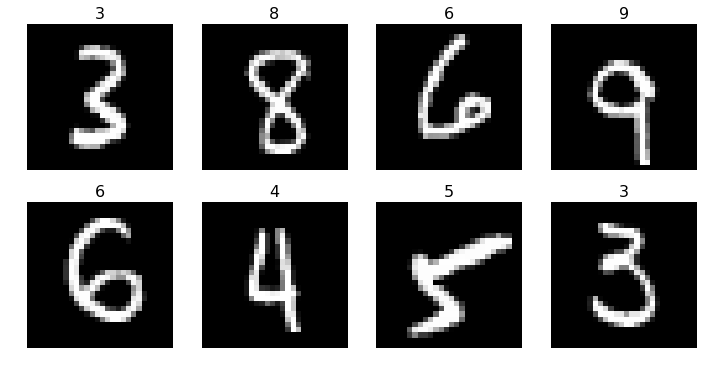

In [54]:
plots(x_imgs[:8], titles=preds[:8])

## Defining Logistic Regression Ourselves

Above, we used pytorch's `nn.Linear` to create a linear layer.  This is defined by a matrix multiplication and then an addition (these are also called `affine transformations`).  Let's try defining this ourselves.

Just as Numpy has `np.matmul` for matrix multiplication (in Python 3, this is equivalent to the `@` operator), PyTorch has `torch.matmul`.  

Our PyTorch class needs two things: constructor (says what the parameters are) and a forward method (how to calculate a prediction using those parameters)  The method `forward` describes how the neural net converts inputs to outputs.

In PyTorch, the optimizer knows to try to optimize any attribute of type **Parameter**.

In [55]:
# divide by size of first axis: He kaiming initialization for weights
def get_weights(*dims): return nn.Parameter(torch.randn(*dims)/dims[0])

In [56]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)    # size is shape, view is reshape; x is a row with shape (784,), we convert it to 2-D (784,1) for matrix multiplication 
        x = torch.matmul(x, self.l1_w) + self.l1_b  # Linear Layer: matrix multiplication
        x = torch.log(torch.exp(x)/(1 + torch.exp(x).sum(dim=0)))        # Non-linear (LogSoftmax) Layer
        return x

In [133]:
# numpy version of 'x.view(x.size(0), -1)'
row = np.random.randn(784,)
row.reshape(row.shape[0],-1)

array([[ 0.17562],
       [ 0.52211],
       [ 0.13324],
       [ 1.35439],
       [-0.38822],
       [ 0.21621],
       [-0.18428],
       [-0.74371],
       [ 0.72659],
       [-0.39506],
       [ 0.44984],
       [ 1.50536],
       [ 0.7401 ],
       [ 0.4709 ],
       [ 0.1996 ],
       [ 1.42008],
       [ 2.10647],
       [-1.20158],
       [-1.32679],
       [ 1.35824],
       [ 1.03882],
       [-0.21743],
       [-1.44798],
       [ 0.38893],
       [ 1.45497],
       [-1.17373],
       [ 2.66716],
       [-0.58554],
       [ 0.19588],
       [-0.27638],
       [ 1.4765 ],
       [-0.38872],
       [-0.31239],
       [ 0.69465],
       [ 0.81343],
       [-2.37351],
       [-0.90034],
       [ 0.42484],
       [ 0.56231],
       [-0.71143],
       [ 1.05749],
       [ 1.47412],
       [ 0.68917],
       [-0.36222],
       [-0.33068],
       [-0.21298],
       [-0.8414 ],
       [ 0.09441],
       [-0.75076],
       [ 0.18698],
       [ 0.30284],
       [ 0.46157],
       [-1.8

In [135]:
# demonstrate linear layer
my_w = np.random.randn(784, 10)
my_b = np.random.randn(10)
np.matmul(row, my_w) + my_b

array([-14.13871, -30.12706,  19.07997,  12.74178, -53.64152,  18.16811, -35.38699, -23.22776,   4.02565,
        -7.87495])

In [66]:
def get_weights(*dims): 
    print(*dims)
    return nn.Parameter(torch.randn(dims)/dims[0])

get_weights(10)

10


Parameter containing:
-0.0096
-0.0029
 0.0384
-0.1888
 0.0481
 0.0641
 0.0042
 0.0737
-0.0592
 0.0211
[torch.FloatTensor of size 10]

In [67]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])
def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])

class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = (x @ self.l1_w) + self.l1_b  # Linear Layer
        x = torch.log(softmax(x)) # Non-linear (LogSoftmax) Layer
        return x

We create our neural net and the optimizer.  (We will use the same loss and metrics from above).

In [68]:
net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

In [69]:
fit(net2, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.33596  0.28211  0.92178]                         



The `fit` method is outputting our accuracy, but we can also calculate it on the validation set:

Let's look at our predictions on the first eight images:

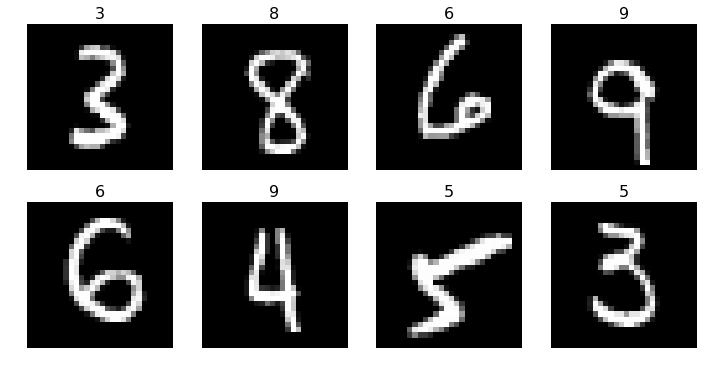

In [74]:
preds = predict(net2, md.val_dl).argmax(1)
plots(x_imgs[:8], titles=preds[:8])

In [75]:
np.mean(preds == y_valid)

0.9214

## Aside about Broadcasting and Matrix Multiplication

Now let's dig in to what we were doing with `torch.matmul`: matrix multiplication.  First, let's start with a simpler building block: **broadcasting**.

### Element-wise operations 

Broadcasting and element-wise operations are supported in the same way by both numpy and pytorch.

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [76]:
a = np.array([10, 6, -4])
b = np.array([2, 8, 7])

In [77]:
a + b

array([12, 14,  3])

In [78]:
a < b

array([False,  True,  True], dtype=bool)

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy, although is now used in other libraries such as [Tensorflow](https://www.tensorflow.org/performance/xla/broadcasting) and Matlab; the rules can vary by library.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

#### Broadcasting with a scalar

In [79]:
a

array([10,  6, -4])

In [80]:
a > 0

array([ True,  True, False], dtype=bool)

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

Remember above when we normalized our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar)?  We were using broadcasting!

Other examples of broadcasting with a scalar:

In [81]:
a + 1

array([11,  7, -3])

In [82]:
m = np.array([[1, 2, 3], [4,5,6], [7,8,9]]); m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [83]:
m * 2

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [84]:
c = np.array([10,20,30]); c

array([10, 20, 30])

In [85]:
m + c

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

Although numpy does this automatically, you can also use the `broadcast_to` method:

In [91]:
c

array([10, 20, 30])

In [86]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [89]:
c[:,None]

array([[10],
       [20],
       [30]])

In [90]:
np.broadcast_to(c[:,None], m.shape)

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

In [97]:
np.expand_dims(c,axis=0)

array([[10, 20, 30]])

In [98]:
np.broadcast_to(np.expand_dims(c,0), (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

The numpy `expand_dims` method lets us convert the 1-dimensional array `c` into a 2-dimensional array (although one of those dimensions has value 1).

In [102]:
np.expand_dims(c,0)

array([[10, 20, 30]])

In [99]:
m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [75]:
m + np.expand_dims(c,0)

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [101]:
np.expand_dims(c,axis=1)

array([[10],
       [20],
       [30]])

In [104]:
c[:, None]

array([[10],
       [20],
       [30]])

In [77]:
m + np.expand_dims(c,1)

array([[11, 12, 13],
       [24, 25, 26],
       [37, 38, 39]])

In [78]:
np.broadcast_to(np.expand_dims(c,1), (3,3))

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

#### Broadcasting Rules

When operating on two arrays, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1

The size of the resulting array is the maximum size along each dimension of the input arrays.
When either of the dimensions compared is one, the other is used. In other words, dimensions with size 1 are stretched or “copied” to match the other.

Missing dimension is treated as 1.  
Arrays do not need to have the same number of dimensions. For example, if you have a $256 \times 256 \times 3$ array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

In the following example, both the `A` and `B` arrays have axes with length one that are expanded to a larger size during the broadcast operation:

    A      (4d array):  8 x 1 x 6 x 1
    B      (3d array):      7 x 1 x 5
    Result (4d array):  8 x 7 x 6 x 5

Here are some more examples:

    A      (2d array):  5 x 4
    B      (1d array):      1
    Result (2d array):  5 x 4

    A      (2d array):  5 x 4
    B      (1d array):      4
    Result (2d array):  5 x 4

    A      (3d array):  15 x 3 x 5
    B      (3d array):  15 x 1 x 5
    Result (3d array):  15 x 3 x 5

    A      (3d array):  15 x 3 x 5
    B      (2d array):       3 x 5
    Result (3d array):  15 x 3 x 5
    
    A      (3d array):  15 x 3 x 5
    B      (2d array):       3 x 1
    Result (3d array):  15 x 3 x 5

Here are examples of shapes that do not broadcast:

    A      (1d array):  3
    B      (1d array):  4 # trailing dimensions do not match

    A      (2d array):      2 x 1
    B      (3d array):  8 x 4 x 3 # second from last dimensions mismatched

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

In [118]:
c

array([10, 20, 30])

In [105]:
c[None]

array([[10, 20, 30]])

In [106]:
c[:,None]

array([[10],
       [20],
       [30]])

In [107]:
c[None] > c[:,None]

array([[False,  True,  True],
       [False, False,  True],
       [False, False, False]], dtype=bool)

In [108]:
xg,yg = np.ogrid[0:5, 0:5]; xg,yg

(array([[0],
        [1],
        [2],
        [3],
        [4]]), array([[0, 1, 2, 3, 4]]))

In [109]:
xg+yg

array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7],
       [4, 5, 6, 7, 8]])

### Matrix Multiplication

We are going to use broadcasting to define matrix multiplication.

#### Matrix-Vector Multiplication

In [111]:
m, c

(array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]), array([10, 20, 30]))

In [112]:
m @ c  # np.matmul(m, c)

array([140, 320, 500])

We get the same answer using `torch.matmul`:

In [113]:
torch.matmul(torch.from_numpy(m), torch.from_numpy(c))


 140
 320
 500
[torch.LongTensor of size 3]

The following is **NOT** matrix multiplication.  What is it?

In [67]:
m * c

array([[ 10,  40,  90],
       [ 40, 100, 180],
       [ 70, 160, 270]])

In [114]:
# get same result as matrix multiplication
(m * c).sum(axis=1)

array([140, 320, 500])

In [115]:
c

array([10, 20, 30])

In [114]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

From a machine learning perspective, matrix multiplication is a way of creating features by saying how much we want to weight each input column.  **Different features are different weighted averages of the input columns**.   
  
(This is matrix multiplication from column's view.)

The website [matrixmultiplication.xyz](http://matrixmultiplication.xyz/) provides a nice visualization of matrix multiplcation

In [119]:
n = np.array([[10,40],[20,0],[30,-5]]); n

array([[10, 40],
       [20,  0],
       [30, -5]])

In [120]:
m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [121]:
m @ n

array([[140,  25],
       [320, 130],
       [500, 235]])

In [122]:
(m * n[:,0]).sum(axis=1)

array([140, 320, 500])

In [123]:
(m * n[:,1]).sum(axis=1)

array([ 25, 130, 235])

### A common use of broadcasting

Color images have an extra dimension, containing RGB values, compared to black & white images.  Fortunately, broadcasting will make it relatively easy to work with this extra dimension.

## Writing Our Own Training Loop

As a reminder, this is what we did above to write our own logistic regression class (as a pytorch neural net):

In [140]:
# Our code from above
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x @ self.l1_w + self.l1_b       # linear layer
        return torch.log(softmax(x))        # non-linear layer

net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

fit(net2, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.32039  0.29739  0.91332]                         



Above, we are using the fastai method `fit` to train our model.  Now we will try writing the training loop ourselves.

**Review question:** What does it mean to train a model?

We will use the LogReg class we created, as well as the same loss function, learning rate, and optimizer as before:

In [143]:
net2 = LogReg().cuda()
loss=nn.NLLLoss()
learning_rate = 1e-3
optimizer=optim.Adam(net2.parameters(), lr=learning_rate)

md is the ImageClassifierData object we created above.  We want an iterable version of our training data (**question**: what does it mean for something to be iterable?):

In [150]:
dl = iter(md.trn_dl) # Data loader

* First, we will do a **forward pass**, which means computing the predicted y by passing x to the model.

In [151]:
# for each mini batch
xt, yt = next(dl)
y_pred = net2(Variable(xt).cuda())   # automatically call forward

In [168]:
to_np(xt).shape, to_np(yt).shape, to_np(y_pred).shape

((64, 784), (64,), (64, 10))

We can check the loss:

In [152]:
# Compute and print loss.
l = loss(y_pred, Variable(yt).cuda())
print(l)

Variable containing:
 2.3221
[torch.cuda.FloatTensor of size 1 (GPU 0)]



We may also be interested in the accuracy.  We don't expect our first predictions to be very good, because the weights of our network were initialized to random values.  Our goal is to see the loss decrease (and the accuracy increase) as we train the network:

In [153]:
# accuracy for each batch
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))  

0.046875

* **backward**: calculate gradient of loss function

Now we will use the optimizer to calculate which direction to step in.  That is, how should we update our weights to try to decrease the loss?

Pytorch has an automatic differentiation package ([autograd](http://pytorch.org/docs/master/autograd.html)) that takes derivatives for us, so we don't have to calculate the derivative ourselves!  We just call `.backward()` on our loss to calculate the direction of steepest descent (the direction to lower the loss the most).

In [154]:
# Before the backward pass, use the optimizer object to zero all of the
# gradients for the variables it will update (which are the learnable weights
# of the model)
optimizer.zero_grad()

# Backward pass: compute gradient of the loss with respect to model parameters
l.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

Now, let's make another set of predictions and check if our loss is lower:

In [155]:
xt, yt = next(dl)
y_pred = net2(Variable(xt).cuda())

In [156]:
# Compute and print loss.
l = loss(y_pred, Variable(yt).cuda())
print(l)

Variable containing:
 2.2294
[torch.cuda.FloatTensor of size 1 (GPU 0)]



<font color='red'>Note that we are using **stochastic** gradient descent, so the loss is not guaranteed to be strictly better each time.  The stochasticity comes from the fact that we are using **mini-batches**; we are just using 64 images to calculate our prediction and update the weights, not the whole dataset.</font>

In [157]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.203125

In [162]:
to_np(y_pred).argmax(axis=1).shape

(64,)

In [166]:
to_np(yt).shape

(64,)

If we run several iterations in a loop, we should see the loss decrease and the accuracy increase with time.

In [158]:
for t in range(100):
    xt, yt = next(dl)
    y_pred = net2(Variable(xt).cuda())
    l = loss(y_pred, Variable(yt).cuda())
    
    if t % 10 == 0:
        accuracy = np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))
        print("loss: ", l.data[0], "\t accuracy: ", accuracy)

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

loss:  2.202951669692993 	 accuracy:  0.34375
loss:  1.4533329010009766 	 accuracy:  0.609375
loss:  1.0839262008666992 	 accuracy:  0.6875
loss:  0.9373473525047302 	 accuracy:  0.734375
loss:  0.6765946745872498 	 accuracy:  0.84375
loss:  0.6157304048538208 	 accuracy:  0.84375
loss:  0.33246418833732605 	 accuracy:  0.953125
loss:  0.6793233156204224 	 accuracy:  0.828125
loss:  0.4741576910018921 	 accuracy:  0.890625
loss:  0.5496132969856262 	 accuracy:  0.90625


### Put it all together in a training loop

GPUs are great at handling lots of data at once (otherwise don't get performance benefit).  We break the data up into **batches**, and that specifies how many samples from our dataset we want to send to the GPU at a time.  The fastai library defaults to a batch size of 64.  On each iteration of the training loop, the error on 1 batch of data will be calculated, and the optimizer will update the parameters based on that.

An **epoch** is completed once each data sample has been used once in the training loop.

In [170]:
def score(x, y):
    y_pred = to_np(net2(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)

In [173]:
net2 = LogReg().cuda()
loss=nn.NLLLoss()
learning_rate = 1e-2
optimizer=optim.SGD(net2.parameters(), lr=learning_rate)

for epoch in range(10):
    losses=[]
    dl = iter(md.trn_dl)
    for t in range(len(dl)):
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = next(dl)
        y_pred = net2(V(xt))
        
        # compute and print loss
        l = loss(y_pred, V(yt))
        losses.append(l)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    # calculate score on validation set for each batch
    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(val_dl))]
    print(np.mean(val_scores))

0.909335191083
0.916401273885
0.917595541401
0.919386942675
0.920581210191
0.921875
0.922770700637
0.923666401274
0.924164012739
0.923268312102


## Stochastic Gradient Descent

Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent (GD)**. In GD you have to run through all the samples in your training set to do a single itaration. In SGD you use only a subset of training samples to do the update for a parameter in a particular iteration. The subset used in each iteration is called a batch or minibatch.

Now, instead of using the optimizer, we will do the optimization ourselves!

In [175]:
net2 = LogReg().cuda()
loss_fn=nn.NLLLoss()
lr = 1e-2
w,b = net2.l1_w,net2.l1_b

for epoch in range(1):
    losses=[]
    dl = iter(md.trn_dl)
    for t in range(len(dl)):
        # Forward pass: compute predicted y by passing x to the model.
        xt, yt = next(dl)
        y_pred = net2.forward(Variable(xt).cuda())

        # Compute and print loss.
        l = loss(y_pred, Variable(yt).cuda())
        losses.append(loss)

        # Before the backward pass, zero the gradients for all of the parameters
        if w.grad is not None:
            w.grad.data.zero_()
            b.grad.data.zero_()   

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()
        w.data -= w.grad.data * lr
        b.data -= b.grad.data * lr
    
    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(val_dl))]
    print(np.mean(val_scores))

0.908837579618


## More about Layers

Sequential defines layers of our network, so let's talk about layers. Neural networks consist of **linear layers alternating with non-linear layers**.  This creates functions which are incredibly flexible.  Deeper layers are able to capture more complex patterns.

Layer 1 of a convolutional neural network:
<img src="images/zeiler1.png" alt="pytorch" style="width: 40%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

Layer 2:
<img src="images/zeiler2.png" alt="pytorch" style="width: 90%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

Deeper layers can learn about more complicated shapes (although we are only using 2 layers in our network):
<img src="images/zeiler4.png" alt="pytorch" style="width: 90%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

Let's add an additional layer to our LogReg model and see if that improves our performance.

In [20]:
net3 = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.LogSoftmax()
).cuda()

In [21]:
loss=nn.NLLLoss()
metrics=[accuracy]
opt=optim.Adam(net3.parameters())

In [23]:
fit(net3, md, epochs=3, crit=loss, opt=opt, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.1048   0.09211  0.97243]                          
[ 1.       0.06213  0.08053  0.97293]                          
[ 2.       0.05496  0.07497  0.97711]                          



By adding an additional layer to our network (with 256 *hidden states*), our accuracy has increased from 91% to 97%.